<a href="https://colab.research.google.com/github/paridhidchoudhary/FineTuning_BERT_Sentiment_Analysis/blob/main/Sentiment_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

df= pd.read_csv('data.csv')

In [2]:
df.head()
#df.describe()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [3]:
from sklearn.model_selection import train_test_split

train_text, temp_text, train_label, temp_label= train_test_split(
    df['sentence'], df['label'],
    random_state=2021,
    test_size=0.3,
    stratify=df['label']
)

val_text, test_text, val_label, test_label= train_test_split(
    temp_text, temp_label,
    random_state=2021,
    test_size=0.5,
    stratify= temp_label
)


Load pretrained BERT Model and Tokenizer

In [4]:
!pip install transformers

In [5]:
import torch
import torch.nn as nn
device=torch.device("cuda")

import transformers
from transformers import AutoModel, BertTokenizerFast


In [6]:
bert= AutoModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
#Load the bert tokenizer
tokenizer= BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(array([1504.,  701.,  572.,  521.,  164.,  215.,  117.,   63.,  104.,
           6.]),
 array([ 3. ,  6.5, 10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. ]),
 <BarContainer object of 10 artists>)

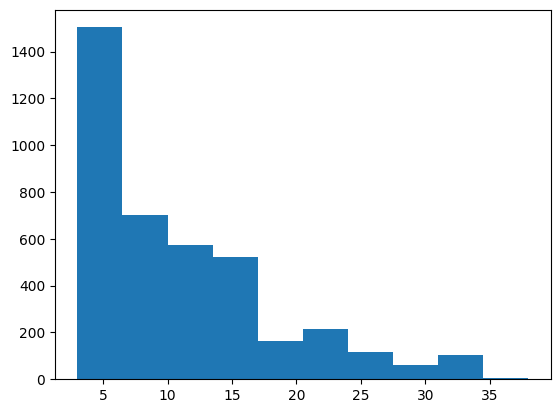

In [8]:
#i.split(), splits the text into words, by splitting on whitespace
import matplotlib.pyplot as plt
train_lens= [len(i.split()) for i in train_text]
plt.hist(train_lens)

In [9]:
# Calculate 90th percentile of word counts
pad_len = int(np.percentile(train_lens, 90))
print(pad_len)

22


In [10]:
#tokenize and encode sequence
tokens_train= tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_test= tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_val= tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=pad_len,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Converting tokenized input data and labels to pytorch tensors since pytorch models expect input to be in the form of tensors.

In [11]:
train_seq= torch.tensor(tokens_train['input_ids'])
train_mask= torch.tensor(tokens_train['attention_mask'])
train_y= torch.tensor(train_label.tolist())

val_seq= torch.tensor(tokens_val['input_ids'])
val_mask= torch.tensor(tokens_val['attention_mask'])
val_y= torch.tensor(val_label.tolist())

test_seq= torch.tensor(tokens_test['input_ids'])
test_mask= torch.tensor(tokens_test['attention_mask'])
test_y= torch.tensor(test_label.tolist())



**Define the model**

Freeze the bert pre-trained model and then add layers.

Difference between Sequential and Random sampler: Sequential sampler iterates through dataset sequentially, in the exact order data is stored. It is best suited for evaluation, inference or testing where the order of data matters.
Random sampler, on the other hand, randomly samples elements from the dataset without replacement. It is typically used in training to introduce randomness in data loading which can improve model generalisation.

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define batch size
batch_size= 16

#wrap data
train_data= TensorDataset(train_seq, train_mask, train_y)

#sample the data
train_sampler= RandomSampler(train_data)

#Dataloader
train_dataloader= DataLoader(train_data, sampler= train_sampler, batch_size=batch_size)

val_data= TensorDataset(val_seq, val_mask, val_y)
val_sampler= SequentialSampler(val_data)
val_dataloader= DataLoader(val_data, sampler= val_sampler, batch_size= batch_size)


#freeze the bert architecture
for param in bert.parameters():
  param.requires_grad= False


Define our own layers in addition to actual Bert architecture

Create a two layer neural network:

First layer: 1.input x= dimension= 768 -> reduce the dimension to 512, h= w^t x + b, h->512X1, w-> 512X768, x-> 768X1, b->512X1

2. Next apply relu activation function , h' = relu(h)
3. Finally, do dropout -> make 20% values zero-> output= h''

Second layer: 1. input : h'' (512X1) -> output : x2(2X1) since the label can be either 0 or 1 -> x2= w^t h'' + b, adjust the weight dimesions accordingly

Finally apply softmax activation on x2, so that the final output comes as probabilities such that the sum of the outputs is always 1

In [13]:
class BERT_Architecture(nn.Module):
  def __init__(self, bert):
    super(BERT_Architecture, self).__init__()
    self.bert= bert

    self.dropout= nn.Dropout(0.2)
    self.relu= nn.ReLU()

    #layer 1
    self.fc1= nn.Linear(768, 512)
    #layer 2->output layer
    self.fc2= nn.Linear(512, 2)

    self.softmax= nn.LogSoftmax(dim=1)

  def forward(self, sent_id, mask):
    _, cls_hs= self.bert(sent_id, attention_mask= mask, return_dict= False)

    x= self.fc1(cls_hs)
    x= self.relu(x)
    x= self.dropout(x)

    x= self.fc2(x)

    x= self.softmax(x)
    return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT_Architecture(bert)
model= model.to(device)

In [19]:
from transformers import AdamW
optimizer= AdamW(model.parameters(), lr= 1e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_label),
                                        y = train_label
                                     )
print("class weights are {} for {}".format(class_weights,np.unique(train_label)))

class weights are [1.14985507 0.88470116] for [0 1]


In [22]:
pd.value_counts(train_label)

<ipython-input-22-3da65106902d>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_label)


,count
label,
1,2242
0,1725


In [28]:
#wrap class weights in tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push weights to GPU
weights = weights.to(device)

# define loss function
# add weights to handle the "imbalance" in the dataset
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 4


In [29]:


# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds




In [30]:


# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds



In [31]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))



 Epoch 1 / 4
  Batch    50  of    248.
  Batch   100  of    248.
  Batch   150  of    248.
  Batch   200  of    248.

Evaluating...
  Batch    50  of     54.

Training Loss: 0.6652986065995309
Validation Loss: 0.6577158791047556

 Epoch 2 / 4
  Batch    50  of    248.
  Batch   100  of    248.
  Batch   150  of    248.
  Batch   200  of    248.

Evaluating...
  Batch    50  of     54.

Training Loss: 0.6575744353955791
Validation Loss: 0.6493081042060146

 Epoch 3 / 4
  Batch    50  of    248.
  Batch   100  of    248.
  Batch   150  of    248.
  Batch   200  of    248.

Evaluating...
  Batch    50  of     54.

Training Loss: 0.6493623191791196
Validation Loss: 0.6405482888221741

 Epoch 4 / 4
  Batch    50  of    248.
  Batch   100  of    248.
  Batch   150  of    248.
  Batch   200  of    248.

Evaluating...
  Batch    50  of     54.

Training Loss: 0.6422392226034596
Validation Loss: 0.6364588075213962


In [32]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))


<ipython-input-32-5a29cc8ec3f6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [33]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()


In [34]:
from sklearn.metrics import classification_report

In [35]:
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))


              precision    recall  f1-score   support

           0       0.89      0.44      0.59       370
           1       0.69      0.96      0.80       481

    accuracy                           0.73       851
   macro avg       0.79      0.70      0.70       851
weighted avg       0.78      0.73      0.71       851

